In [109]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from keras.models import Sequential, load_model
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

from IPython.display import Markdown, display

def print_md(text):
    display(Markdown(text))

# Data Preview

# --- Rock ---

### Total images: 726

### Random image:

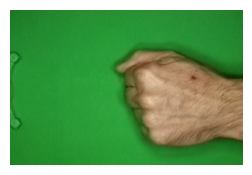

# --- Paper ---

### Total images: 712

### Random image:

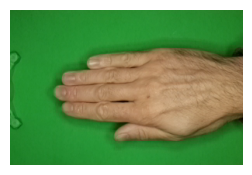

# --- Scissors ---

### Total images: 750

### Random image:

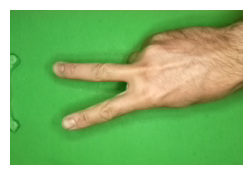

### Image sizes: {(300, 200)}

In [110]:
# Our 3 states
states = ['rock','paper','scissors']
label_mapping = {'rock': 0,
                 'paper': 1, 
                 'scissors': 2}

unique_sizes = set()

for state in states:
    
    # Get a list of our image filess
    image_files = os.listdir(state)
    
#     image_files = [file for file in files]

    random_image_name = random.choice(image_files)
    random_image_path = os.path.join(state, random_image_name)
    
    print_md(f"# --- {state.title()} ---")
    print_md(f"### Total images: {len(image_files)}")
    print_md('### Random image:')
    image = Image.open(random_image_path)
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.imshow(image)
    ax.axis('off')
    plt.show()
    
    # Save the image sizes to check the required preprocessing needed
    for img_name in image_files:
        img_path = os.path.join(state, img_name)
        with Image.open(img_path) as img:
            unique_sizes.add(img.size)
    
print_md(f'### Image sizes: {unique_sizes}')

# Data Preprocessing

In [111]:
def remove_green_background(image_path):
    
    image = cv2.imread(image_path)
    image = cv2.resize(image, (150, 100))  
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lower_green = np.array([36, 25, 25])
    upper_green = np.array([86, 255, 255])

    # Create a mask to detect green areas
    mask = cv2.inRange(hsv, lower_green, upper_green)

    # Inverse mask to get parts that are not green
    mask_inv = cv2.bitwise_not(mask)

    # Convert non-green areas to white
    image[mask_inv == 0] = [255, 255, 255]

    return image

In [112]:
def add_noise(image, mean=0, std=0.05): # std = 1 * 5%
    
    gaussian_noise = np.random.normal(mean, std, image.shape)
    noisy_image = image + gaussian_noise

    # Clip the image pixel values to be in the range [0, 1]
    noisy_image = np.clip(noisy_image, 0, 1)
    return noisy_image

In [116]:
dataset = []

for state in states:

    image_files = os.listdir(state)
    state_label = label_mapping[state]

    for image in image_files:
        
        # img=load_img(os.path.join(state,image), target_size=(150,150))
        # img=img_to_array(img)

        img = remove_green_background(os.path.join(state,image))
        
        img=img/255.0
        
        img_noisy = add_noise(img)  # Add noise
        
        dataset.append((img_noisy,state_label))
    
random.shuffle(dataset)
X_tuple, y_tuple = zip(*dataset)

X = np.array(X_tuple)
y= np.array(y_tuple)

In [117]:
print_md(f'### Data Shape: {X.shape}')
print_md(f'### Labels Shape: {y.shape}')

### Data Shape: (2188, 100, 150, 3)

### Labels Shape: (2188,)

In [142]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0, stratify=y)

# Model

In [152]:
model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=(100,150,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=3, activation='softmax'))


model.summary()

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 98, 148, 32)       896       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 49, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 47, 72, 32)        9248      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 23, 36, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_7 (Flatten)         (None, 26496)             0         
                                                                 
 dense_14 (Dense)            (None, 512)              

In [144]:
# One-hot encoding
nb = len(states)
y_train = np.eye(nb)[y_train]
y_test = np.eye(nb)[y_test]

In [162]:
datagen = ImageDataGenerator(horizontal_flip=True, # 50% chance for horizontal flip
                             vertical_flip=True) # 50% chance for vertical flip

batch_size = 32
epochs = 10

# Generators for image augmentation
train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)
test_generator = datagen.flow(X_test, y_test, batch_size=batch_size)

# Model fit
model_history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=len(X_test) // batch_size
)

Epoch 1/10
54/54 [==============================] - 5s 97ms/step - loss: 5.8597e-06 - accuracy: 1.0000 - val_loss: 0.4159 - val_accuracy: 0.9639
Epoch 2/10
54/54 [==============================] - 5s 95ms/step - loss: 5.0663e-06 - accuracy: 1.0000 - val_loss: 0.4280 - val_accuracy: 0.9663
Epoch 3/10
54/54 [==============================] - 5s 94ms/step - loss: 4.4946e-06 - accuracy: 1.0000 - val_loss: 0.3570 - val_accuracy: 0.9736
Epoch 4/10
54/54 [==============================] - 5s 93ms/step - loss: 4.5673e-06 - accuracy: 1.0000 - val_loss: 0.3908 - val_accuracy: 0.9639
Epoch 5/10
54/54 [==============================] - 5s 93ms/step - loss: 4.8747e-06 - accuracy: 1.0000 - val_loss: 0.3910 - val_accuracy: 0.9712
Epoch 6/10
54/54 [==============================] - 5s 93ms/step - loss: 4.8262e-06 - accuracy: 1.0000 - val_loss: 0.2735 - val_accuracy: 0.9760
Epoch 7/10
54/54 [==============================] - 5s 93ms/step - loss: 5.0365e-06 - accuracy: 1.0000 - val_loss: 0.4009 - val_ac

In [167]:
model.save('rpc_model.keras')

# Results

In [164]:
y_pred = model.predict(X_test)
pred = np.argmax(y_pred,axis=1)

ground = np.argmax(y_test,axis=1)

print(classification_report(ground,pred,target_names = states))

14/14 [==============================] - 0s 14ms/step
              precision    recall  f1-score   support

        rock       0.96      0.99      0.98       145
       paper       0.96      0.94      0.95       143
    scissors       0.98      0.97      0.97       150

    accuracy                           0.97       438
   macro avg       0.97      0.97      0.97       438
weighted avg       0.97      0.97      0.97       438



# Rock-Paper-Scissor Game Enviroment

In [31]:
model = load_model('rpc_model.keras')

In [165]:
# Preprocessing function for the input images
def preprocess_image(image_path):
    # img = load_img(image_path, target_size=(150, 150))
    # img = img_to_array(img)
    img = remove_green_background(image_path)
    img = img / 255.0 
    img = np.expand_dims(img, axis=0)
    return img

In [156]:
def computer_answer(image_path):

    processed_image = preprocess_image(image_path)
    prediction = model.predict(processed_image)

    class_index = np.argmax(prediction)
    prediction_mapping = {0: 'rock', 1: 'paper', 2: 'scissors'}
    predicted_move = prediction_mapping[class_index]

    match predicted_move:
        case 'rock':
            return 'paper'
        case 'paper':
            return 'scissors'
        case 'scissors':
            return 'rock'

In [149]:
def display_images_side_by_side(image_path1, image_path2, header1, header2):
    # Load the images
    img1 = mpimg.imread(image_path1)
    img2 = mpimg.imread(image_path2)

    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(4, 4))  # Adjust figure size as needed

    # Display first image
    axs[0].imshow(img1)
    axs[0].set_title(header1)
    axs[0].axis('off')  # Turn off axis

    # Display second image
    axs[1].imshow(img2)
    axs[1].set_title(header2)
    axs[1].axis('off')  # Turn off axis

    # Show the plot
    plt.show()


1/1 [==============================] - 0s 18ms/step


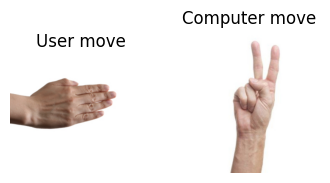

1/1 [==============================] - 0s 16ms/step


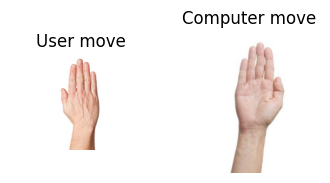

1/1 [==============================] - 0s 16ms/step


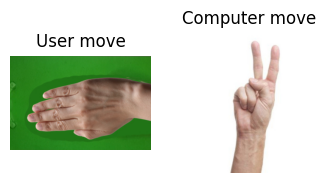

1/1 [==============================] - 0s 17ms/step


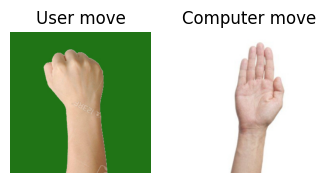

1/1 [==============================] - 0s 16ms/step


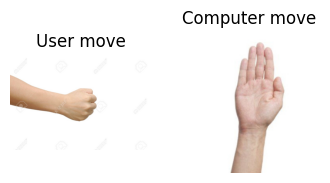

1/1 [==============================] - 0s 17ms/step


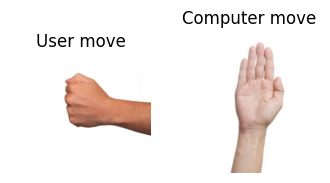

1/1 [==============================] - 0s 17ms/step


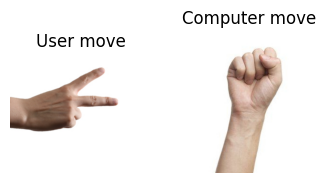

1/1 [==============================] - 0s 15ms/step


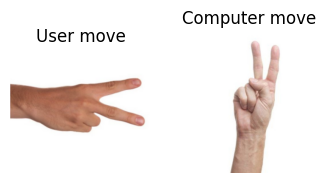

1/1 [==============================] - 0s 19ms/step


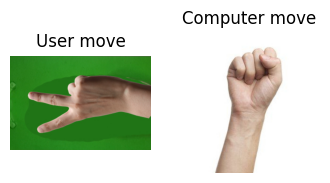

In [166]:
test_images_dir = 'test_images'
response_images_dir = 'response_images'

for test_image in os.listdir(test_images_dir):

    user_image_path = os.path.join(test_images_dir, test_image)
    
    computer_move = computer_answer(user_image_path)
    computer_image_path = os.path.join(response_images_dir, f'{computer_move}.jpg')

    display_images_side_by_side(user_image_path, computer_image_path, 'User move', 'Computer move')